# [Optional 10 points] Part 3. Topic model

In [14]:
!pip install gensim

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import re
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.decomposition import NMF
from gensim import corpora
from gensim.models import Nmf, LdaModel, CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
pio.renderers.default='notebook'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [3]:
#os.chdir('//Users//alyaatmaeva//Desktop//itmo//Adv_Natural_Language_Processing//ANLP-2022-materials//Homeworks')
topic_df = pd.read_csv('/content/drive/My Drive/data.csv')
#topic_df = pd.read_csv('data.csv')

The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing

In [ ]:
#topic_df = pd.read_csv('data.csv')

In [4]:
topic_df.head(5)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


<AxesSubplot:xlabel='author', ylabel='id'>

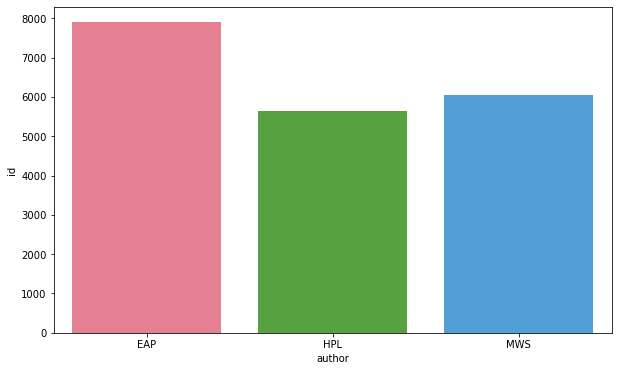

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x = 'author', y ='id', data = topic_df.groupby(['author'], as_index=False)['id'].count(), palette = "husl" )


In [7]:
topic_df.drop(['id'], axis = 1, inplace = True)

## Preprocess dataset

In [8]:
nltk.download("stopwords")
nltk.download('punkt')  
nltk.download('wordnet')
nltk.download('words')
  
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
words_eng = set(nltk.corpus.words.words())
my_stop_words = set(['url','x','us','th'])
stop_words.update(my_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
def preprocessing(line):
    soup = BeautifulSoup(line, "html.parser")
    for data in soup(['style', 'script','a']):
        data.decompose()
    clean_text = ' '.join(soup.stripped_strings)
    # delete numbers and all other symbols except letters
    clean_text = re.sub(r'[0-9]+', '', clean_text)
    clean_text = re.sub(r"[^\w\s]", '', clean_text )
    clean_text = re.sub(r'\n+', '\n',  clean_text) 
    clean_text = re.sub(r'[^\x00-\x7f]',r' ', clean_text)
    #tokenization 
    tokinized_words = word_tokenize(clean_text)
    #lower 
    words = [token.lower() for token in tokinized_words \
                        if (token.isalpha()
                            and token.lower()   not in stop_words ) 
                        ] 


    # lemmatization
    words = [lemmatizer.lemmatize(i) for i in words]
     #remove non-english words 
    words = [word for word in words if word  in words_eng and len(word)>1]
    return ' '.join(words)
    

In [10]:
clean_text_topic = []
for i in range(len(topic_df)):
    f = preprocessing(topic_df.loc[i].text)
    clean_text_topic.append(f)

In [11]:
topic_df['clean_text'] = clean_text_topic 

In [12]:
topic_df.loc[2].clean_text

'left hand gold snuff box hill cutting manner fantastic step took snuff incessantly air possible self satisfaction'

In [13]:
clean_text_topic[15]

'must commence destructive almost endless journey across mountainous ice ocean amidst cold inhabitant could long endure native genial sunny climate could hope survive'

## Quality estimation

In [21]:
#quality fuctions
def coherence(model, texts, dictionary):
    coherence = CoherenceModel(model=model, texts=texts,
        dictionary=dictionary, coherence='c_v')
    return coherence.get_coherence()

def nmpi(model, texts, dictionary):
    nmpi = CoherenceModel(model=model, texts=texts,
        dictionary=dictionary, coherence='c_npmi')
    return nmpi.get_coherence()

def mass(model, texts, dictionary):   
    mass = CoherenceModel(model=model, texts=texts,
        dictionary=dictionary, coherence='u_mass')
    return mass.get_coherence()

## Topic modeling

In [14]:
X = topic_df['clean_text']
y = topic_df['author']

In [15]:
most_common_words_topic_df = pd.Series(' '.join(topic_df['clean_text']).split()).value_counts()[:100].reset_index().rename({'index':'words', 0:'frequency'},axis='columns')

Text(0.5, 1.0, 'Most common words')

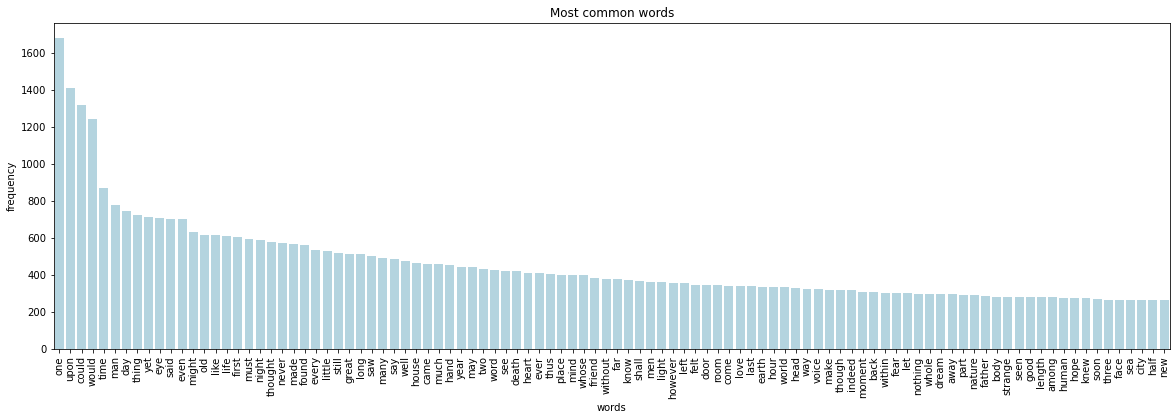

In [16]:
plt.figure(figsize=(20,6))
fig = sns.barplot( x='words',y='frequency', data = most_common_words_topic_df, color = 'lightblue')
plt.xticks(rotation=90)
fig.set_title('Most common words')

### NMF

In [18]:

X_token = []

for index in range(len(X)):
    X_token.append(X[index].split())

dictionary = corpora.Dictionary(X_token)
corpus = [dictionary.doc2bow(text) for text in X_token]

#Model
nmf = Nmf(corpus, num_topics=10, id2word=dictionary)
nmf_topics = nmf.print_topics(num_words=10)

for i,topic in enumerate(nmf_topics):
    print("\nTopic #{}:".format(i))
    print(topic)
    print("-"*70)



Topic #0:
(0, '0.033*"could" + 0.026*"little" + 0.020*"even" + 0.016*"might" + 0.015*"must" + 0.013*"may" + 0.010*"man" + 0.008*"make" + 0.008*"friend" + 0.008*"body"')
----------------------------------------------------------------------

Topic #1:
(1, '0.044*"one" + 0.026*"man" + 0.021*"well" + 0.013*"old" + 0.013*"two" + 0.012*"head" + 0.012*"year" + 0.010*"night" + 0.005*"came" + 0.005*"many"')
----------------------------------------------------------------------

Topic #2:
(2, '0.090*"could" + 0.025*"one" + 0.017*"say" + 0.012*"eye" + 0.008*"human" + 0.007*"whose" + 0.007*"seen" + 0.006*"time" + 0.006*"world" + 0.006*"beyond"')
----------------------------------------------------------------------

Topic #3:
(3, '0.073*"said" + 0.023*"thought" + 0.018*"man" + 0.013*"hand" + 0.012*"saw" + 0.008*"word" + 0.006*"would" + 0.005*"thus" + 0.005*"eye" + 0.005*"take"')
----------------------------------------------------------------------

Topic #4:
(4, '0.033*"never" + 0.022*"time" + 

In [22]:
print("NMF model")
print ("coherence: {}".format(coherence(model=nmf, texts=X_token, dictionary=dictionary)))
print("nmpi: {}".format(nmpi(model=nmf, texts=X_token, dictionary=dictionary)))
print("mass: {}".format(mass(model=nmf, texts=X_token, dictionary=dictionary)))

NMF model
coherence: 0.4179425756828666
nmpi: -0.017224484496307754
mass: -3.719182617188457


### LDA

In [24]:
lda = LdaModel(corpus, num_topics=10 , id2word=dictionary)
lda_topics = lda.print_topics(num_words=20)

for i,topic in enumerate(lda_topics):
    print("\nTopic #{}:".format(i))
    print(topic)
    print("-"*70)


Topic #0:
(0, '0.011*"could" + 0.010*"said" + 0.009*"upon" + 0.009*"would" + 0.008*"great" + 0.008*"day" + 0.007*"thing" + 0.007*"one" + 0.007*"see" + 0.006*"nothing" + 0.006*"three" + 0.006*"let" + 0.006*"way" + 0.005*"made" + 0.005*"done" + 0.004*"time" + 0.004*"boy" + 0.004*"go" + 0.004*"say" + 0.004*"much"')
----------------------------------------------------------------------

Topic #1:
(1, '0.021*"one" + 0.008*"time" + 0.007*"may" + 0.007*"could" + 0.006*"every" + 0.006*"little" + 0.006*"would" + 0.005*"yet" + 0.005*"upon" + 0.005*"word" + 0.005*"might" + 0.005*"much" + 0.005*"say" + 0.005*"never" + 0.004*"man" + 0.004*"life" + 0.004*"thought" + 0.004*"must" + 0.004*"even" + 0.004*"ever"')
----------------------------------------------------------------------

Topic #2:
(2, '0.015*"would" + 0.012*"could" + 0.008*"shall" + 0.007*"oh" + 0.007*"name" + 0.006*"might" + 0.006*"life" + 0.006*"hope" + 0.006*"said" + 0.006*"best" + 0.006*"well" + 0.005*"death" + 0.005*"voice" + 0.005*"

In [25]:
print("LDA model")
print ("coherence: {}".format(coherence(model=lda, texts=X_token, dictionary=dictionary)))
print("nmpi: {}".format(nmpi(model=lda, texts=X_token, dictionary=dictionary)))
print("mass: {}".format(mass(model=lda, texts=X_token, dictionary=dictionary)))

LDA model
coherence: 0.2982391170590597
nmpi: -0.03529665917943201
mass: -4.166346641914737


In [26]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=lda.id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.035932 -0.014981       1        1  13.905319
7      0.050032  0.025259       2        1  13.484923
5     -0.114151  0.042996       3        1  12.032406
6     -0.099121  0.099617       4        1   9.820873
3     -0.085082 -0.048190       5        1   9.489567
0      0.025097 -0.125821       6        1   9.045516
4     -0.089080 -0.064689       7        1   8.699382
8      0.060807  0.218420       8        1   8.276233
9     -0.046742 -0.093365       9        1   7.832292
2      0.262308 -0.039244      10        1   7.413490, topic_info=       Term         Freq        Total Category  logprob  loglift
144   would  1265.000000  1265.000000  Default  30.0000  30.0000
389    upon  1483.000000  1483.000000  Default  29.0000  29.0000
121   could  1391.000000  1391.000000  Default  28.0000  28.0000
915  friend   374.000000   374.000000  Default  27.0000  27.0000
376    said   722.000000   722.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
424    ever    61.525417   455.894189  Topic10  -5.5906   0.5991
141    thus    57.626406   405.313615  Topic10  -5.6561   0.6512
6      make    56.207852   350.865430  Topic10  -5.6810   0.7705
198    must    56.280082   659.788803  Topic10  -5.6797   0.1403
915  friend    56.126438   374.426941  Topic10  -5.6825   0.7041

[805 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2048      9  0.969913     accompany
874       8  0.970333    accustomed
4281      2  0.017487  acquaintance
4281      9  0.961803  acquaintance
422       1  0.287814           act
...     ...       ...           ...
99        3  0.171855         youth
99        4  0.532750         youth
99        7  0.042964         youth
99        8  0.214818         youth
99       10  0.034371         youth

[2256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 6, 7, 4, 1, 5, 9, 10, 3])

## Additive regularization of topic models 

In [19]:
!pip install bigartm

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [20]:
import artm

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

In [27]:
#ARTM model 
model_dict_create = artm.Dictionary()
model_dict_create.gather(data_path= bv.data_path)
model_dict_create.save_text(dictionary_path = 'dict.txt')

In [28]:
model_dict = artm.Dictionary()
model_dict.load_text(dictionary_path = 'dict.txt')

In [60]:
#ARTM model 
#batch_vectorizer

cv = CountVectorizer(max_features=1000, stop_words='english')
n_wd = array(cv.fit_transform(X).todense()).T
vocabulary = cv.get_feature_names()

bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=vocabulary)
n = 10
topic_names = ['topic_{}'.format(i) for i in range(n)]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [82]:
artm_1 = artm.ARTM(num_topics=n, 
                            topic_names=topic_names , dictionary=model_dict
                   , scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=model_dict)]
                   ,regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.15)]
                   ,cache_theta = True)

         
artm_2 = artm.ARTM(num_topics=n, 
                            topic_names=topic_names , dictionary=model_dict
                   , scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=model_dict)]
            
                   ,cache_theta = True)


artm_3 = artm.ARTM(num_topics=n, 
                            topic_names=topic_names , dictionary=model_dict
                   , scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=model_dict)]
                    ,regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.55)]
                   ,cache_theta = True)

In [83]:

#artm_1.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
artm_1.scores.add(artm.TopTokensScore(name='TopTokensScore',num_tokens=50))
artm_1.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
artm_1.scores.add(artm.SparsityThetaScore(name='SparsityPhiScore'))
artm_1.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))

artm_1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_reg',tau = -0.1))
artm_1.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_reg',tau = -0.15))
artm_1.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorellator_phi_reg',tau = 1.5e+5))



artm_2.scores.add(artm.TopTokensScore(name='TopTokensScore',num_tokens=50))
artm_2.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
artm_2.scores.add(artm.SparsityThetaScore(name='SparsityPhiScore'))
artm_2.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))

artm_3.scores.add(artm.TopTokensScore(name='TopTokensScore',num_tokens=100))
artm_3.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
artm_3.scores.add(artm.SparsityThetaScore(name='SparsityPhiScore'))
artm_3.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.5))

artm_3.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_reg',tau = -0.25))
artm_3.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_reg',tau = -1))
artm_3.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorellator_phi_reg',tau = 5.5e+5))


In [84]:
artm_1.num_document_passes = 1
artm_2.num_document_passes = 1
artm_3.num_document_passes = 1

artm_1.fit_offline(bv, num_collection_passes=20)
artm_2.fit_offline(bv, num_collection_passes=20)
artm_3.fit_offline(bv, num_collection_passes=20)

In [85]:
for i, topic_name in enumerate(artm_1.topic_names):
      print("\nTopic #{}:".format(i))
      print(artm_1.score_tracker['TopTokensScore'].last_tokens[topic_name])
      print("-"*70)



Topic #0:
['night', 'mind', 'room', 'felt', 'let', 'dream', 'away', 'strange', 'human', 'soon', 'return', 'change', 'doubt', 'spoke', 'mountain', 'state', 'longer', 'tear', 'poor', 'rest', 'figure', 'affection', 'passion', 'leave', 'bed', 'week', 'necessary', 'impossible', 'sister', 'design', 'escape', 'kept', 'girl', 'party', 'various', 'plague', 'later', 'danger', 'horrible', 'fate', 'tried', 'apartment', 'struck', 'fallen', 'bring', 'wished', 'outside', 'cried', 'daughter', 'respect']
----------------------------------------------------------------------

Topic #1:
['life', 'great', 'year', 'word', 'heart', 'left', 'head', 'new', 'look', 'dark', 'certain', 'manner', 'sight', 'reason', 'question', 'fell', 'heaven', 'attention', 'age', 'believe', 'possible', 'wonder', 'given', 'event', 'happiness', 'happy', 'natural', 'cold', 'discovered', 'knowledge', 'altogether', 'hear', 'green', 'sorrow', 'hold', 'usual', 'vision', 'number', 'live', 'especially', 'single', 'cut', 'lord', 'beloved

In [86]:
for i, topic_name in enumerate(artm_2.topic_names):
      print("\nTopic #{}:".format(i))
      print(artm_2.score_tracker['TopTokensScore'].last_tokens[topic_name])
      print("-"*70)



Topic #0:
['night', 'mind', 'felt', 'room', 'let', 'away', 'strange', 'soon', 'change', 'doubt', 'spoke', 'mountain', 'state', 'return', 'longer', 'tear', 'poor', 'spirit', 'dear', 'rest', 'figure', 'affection', 'passion', 'leave', 'bed', 'week', 'necessary', 'impossible', 'sister', 'escape', 'girl', 'kept', 'party', 'various', 'plague', 'later', 'danger', 'horrible', 'fate', 'tried', 'apartment', 'struck', 'fallen', 'servant', 'ala', 'wished', 'feature', 'bring', 'cried', 'outside']
----------------------------------------------------------------------

Topic #1:
['great', 'year', 'word', 'heart', 'head', 'dream', 'new', 'look', 'manner', 'sight', 'town', 'dark', 'reason', 'question', 'fell', 'heaven', 'certain', 'attention', 'believe', 'possible', 'eye', 'wonder', 'given', 'event', 'happy', 'discovered', 'knowledge', 'altogether', 'hear', 'green', 'sorrow', 'hold', 'usual', 'vision', 'live', 'especially', 'cut', 'single', 'lord', 'beloved', 'closed', 'public', 'broken', 'frame', 'fo

In [87]:
for i, topic_name in enumerate(artm_3.topic_names):
      print("\nTopic #{}:".format(i))
      print(artm_3.score_tracker['TopTokensScore'].last_tokens[topic_name])
      print("-"*70)


Topic #0:
['art', 'meaning', 'mere', 'morning', 'circumstance']
----------------------------------------------------------------------

Topic #1:
['place', 'make', 'dead', 'scene', 'change', 'manner', 'took', 'white', 'wind', 'sight', 'kind', 'space', 'shadow', 'degree', 'fell', 'cold', 'return', 'fact', 'past', 'despair', 'hear', 'calm', 'green', 'existence', 'cottage', 'field', 'youth', 'blue', 'boy', 'angle', 'kept', 'bosom', 'sympathy', 'rise', 'school', 'unusual', 'midnight', 'behold', 'complete']
----------------------------------------------------------------------

Topic #2:
['thy', 'ear']
----------------------------------------------------------------------

Topic #3:
['ye', 'thousand', 'good', 'tell', 'mean', 'ancient', 'tale', 'ago', 'pleasure', 'cat', 'devil', 'filled', 'brow']
----------------------------------------------------------------------

Topic #4:
['room', 'horror', 'star', 'right', 'brought', 'terror', 'lost', 'atmosphere', 'theory', 'use', 'live', 'boat']
---

Write a function to convert new documents to topics probabilities vectors.

In [88]:
topics = artm_1.transform(bv)
topics

,14000,14001,14002,14003,14004,14005,14006,14007,14008,14009,...,19569,19570,19571,19572,19573,19574,19575,19576,19577,19578
topic_0,0.000000,0.000000,0.092896,0.000000,0.000000,0.113146,0.333333,0.184783,0.000000,0.000000,...,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.1,0.0,0.0,0.0
topic_1,0.000000,0.333333,0.256831,0.000000,0.102941,0.113146,0.000000,0.075986,0.000000,0.000000,...,0.0,0.000000,0.000000,0.303371,0.000000,0.0,0.1,0.0,0.0,0.5
topic_2,0.330954,0.000000,0.038251,0.000000,0.247182,0.000000,0.000000,0.184783,0.354167,0.000000,...,0.5,0.215190,0.447368,0.078652,0.000000,0.5,0.1,0.0,0.0,0.0
topic_3,0.000000,0.000000,0.092896,0.725490,0.000000,0.000000,0.000000,0.000000,0.145833,0.548387,...,0.0,0.088608,0.184211,0.191011,0.548387,0.0,0.1,0.0,0.5,0.0
topic_4,0.000000,0.000000,0.038251,0.000000,0.000000,0.113146,0.333333,0.184884,0.000000,0.225806,...,0.0,0.215190,0.184211,0.078652,0.000000,0.0,0.1,0.0,0.5,0.0
topic_5,0.333333,0.000000,0.038251,0.137255,0.250000,0.110995,0.333333,0.184783,0.000000,0.225806,...,0.0,0.215190,0.000000,0.000000,0.225806,0.0,0.1,0.0,0.0,0.0
topic_6,0.000000,0.000000,0.366120,0.000000,0.000000,0.436421,0.000000,0.000000,0.000000,0.000000,...,0.0,0.088608,0.000000,0.078652,0.000000,0.0,0.1,0.0,0.0,0.0
topic_7,0.000000,0.000000,0.038251,0.000000,0.399877,0.000000,0.000000,0.000000,0.354167,0.000000,...,0.0,0.088608,0.000000,0.191011,0.225806,0.0,0.1,1.0,0.0,0.0
topic_8,0.000000,0.333333,0.000000,0.137255,0.000000,0.113146,0.000000,0.000000,0.145833,0.000000,...,0.0,0.000000,0.184211,0.000000,0.000000,0.0,0.1,0.0,0.0,0.0
topic_9,0.335713,0.333333,0.038251,0.000000,0.000000,0.000000,0.000000,0.184783,0.000000,0.000000,...,0.0,0.088608,0.000000,0.078652,0.000000,0.5,0.1,0.0,0.0,0.5


Calculate the quality scores for each model. Make a barplot to compare the quality.

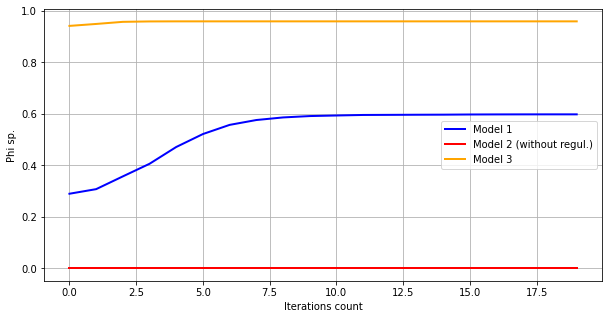

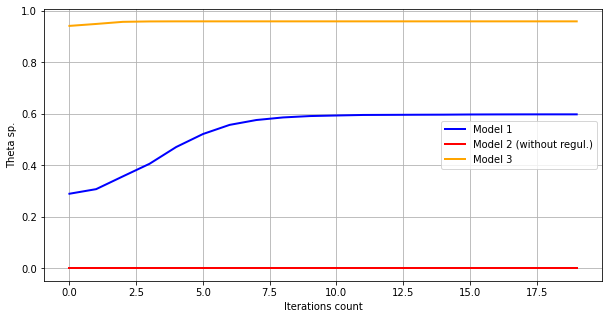

In [89]:
plt.figure( figsize = (10,5) )
plt.plot(range(artm_1.num_phi_updates), artm_1.score_tracker['SparsityPhiScore'].value, 'b',
         range(artm_2.num_phi_updates), artm_2.score_tracker['SparsityPhiScore'].value, 'r',
         range(artm_3.num_phi_updates), artm_3.score_tracker['SparsityPhiScore'].value, 'orange',
         linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sp.')
plt.legend(['Model 1', 'Model 2 (without regul.)', 'Model 3'])
plt.grid(True)
plt.show()

plt.figure( figsize = (10,5) )
plt.plot(range(artm_1.num_phi_updates), artm_1.score_tracker['SparsityThetaScore'].value, 'b',
         range(artm_2.num_phi_updates), artm_2.score_tracker['SparsityThetaScore'].value, 'r', 
         range(artm_3.num_phi_updates), artm_3.score_tracker['SparsityThetaScore'].value, 'orange', 
         linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Theta sp.')
plt.legend(['Model 1', 'Model 2 (without regul.)', 'Model 3'])
plt.grid(True)
plt.show()

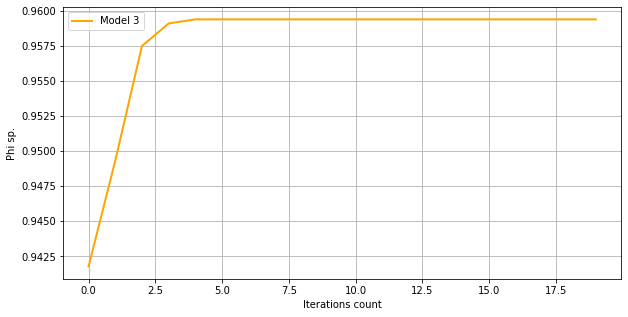

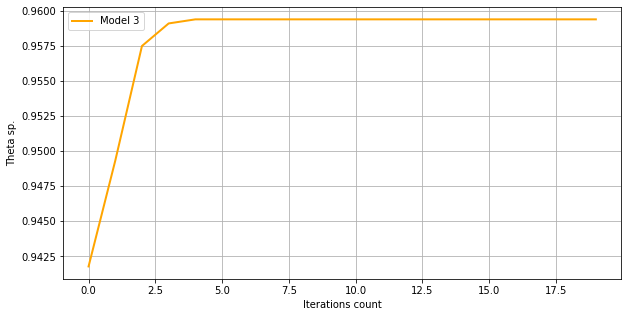

In [90]:
# THE BEST MODEL 3

plt.figure( figsize = (10,5) )
plt.plot(range(artm_3.num_phi_updates), artm_3.score_tracker['SparsityPhiScore'].value, 'orange',
         linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sp.')
plt.legend(['Model 3'])
plt.grid(True)
plt.show()

plt.figure( figsize = (10,5) )
plt.plot(range(artm_3.num_phi_updates), artm_3.score_tracker['SparsityThetaScore'].value, 'orange', 
         linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Theta sp.')
plt.legend(['Model 3'])
plt.grid(True)
plt.show()

Adding a regularizer and varying the parameters improves the quality of the model

In [111]:
def measures(model_1, model_2, model_3):
    df = pd.DataFrame(data = {"model" : ['model 1', 'model 2', 'model 3']})
    df['SparsityPhiScore'] = [model_1.score_tracker['SparsityPhiScore'].last_value,
        model_2.score_tracker['SparsityPhiScore'].last_value,
        model_3.score_tracker['SparsityPhiScore'].last_value]
    df['SparsityThetaScore'] = [model_1.score_tracker['SparsityThetaScore'].last_value,
        model_2.score_tracker['SparsityThetaScore'].last_value,
        model_3.score_tracker['SparsityThetaScore'].last_value]
    df['Kernel contrast'] = [model_1.score_tracker['TopicKernelScore'].last_average_contrast,
        model_2.score_tracker['TopicKernelScore'].last_average_contrast,
        model_3.score_tracker['TopicKernelScore'].last_average_contrast]
    df['Kernel purity'] = [model_1.score_tracker['TopicKernelScore'].last_average_purity,
        model_2.score_tracker['TopicKernelScore'].last_average_purity,
        model_3.score_tracker['TopicKernelScore'].last_average_purity]
    df['Perplexity'] = [model_1.score_tracker['PerplexityScore'].last_value,
        model_2.score_tracker['PerplexityScore'].last_value,
        model_3.score_tracker['PerplexityScore'].last_value]

    return df 
    
measures_res = measures(artm_1, artm_2,artm_3)


In [113]:
measures_res

,model,SparsityPhiScore,SparsityThetaScore,Kernel contrast,Kernel purity,Perplexity
0,model 1,0.598304,0.598304,0.991662,0.988206,323.820557
1,model 2,0.000000,0.000000,0.958817,0.978035,329.947723
2,model 3,0.959405,0.959405,1.000000,1.000000,662.834595


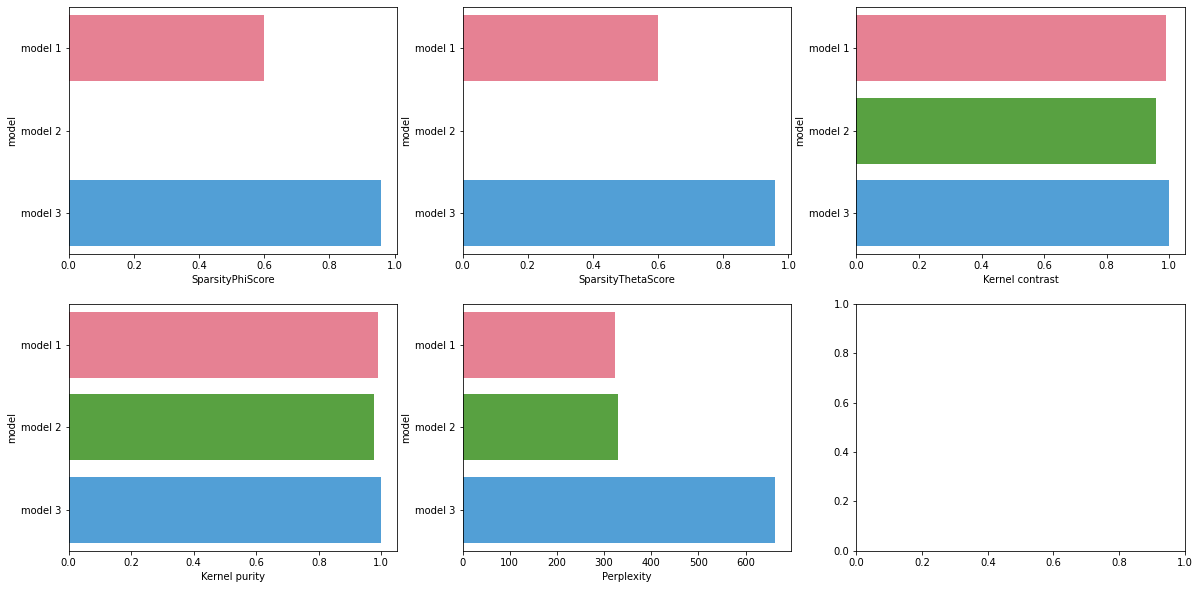

In [122]:
figure, ax = plt.subplots(2, 3, figsize=(20, 10))

sns.barplot(x = 'SparsityPhiScore', y ='model',ax=ax[0, 0], data = measures_res[['model','SparsityPhiScore']] , palette = "husl" )
sns.barplot(x = 'SparsityThetaScore', y ='model',ax=ax[0, 1], data = measures_res[['model','SparsityThetaScore']] , palette = "husl" )
sns.barplot(x = 'Kernel contrast', y ='model',ax=ax[0, 2], data = measures_res[['model','Kernel contrast']] , palette = "husl" )
sns.barplot(x = 'Kernel purity', y ='model', ax=ax[1, 0], data = measures_res[['model','Kernel purity']] , palette = "husl" )
sns.barplot(x = 'Perplexity', y ='model', ax=ax[1, 1], data = measures_res[['model','Perplexity']] , palette = "husl" )
plt.show()